In [1]:
import scanpy as sc
import scipy.stats
import pandas as pd
from tqdm.contrib.concurrent import process_map
from tqdm import tqdm
import statsmodels.stats.multitest
import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import anndata
import matplotlib.pyplot as plt

anndata.logging.anndata_logger.addFilter(
    lambda r: not r.getMessage().startswith("storing")
    and r.getMessage().endswith("as categorical.")
)

In [2]:
out_dir = "../../data/70_de_analysis/78b_cooccurence"

In [3]:
!mkdir -p {out_dir}

In [4]:
ad = sc.read_h5ad("../../data/30_merge_adata/adata_scvi.h5ad")

In [5]:
gene_of_interest = "LGR5"

In [6]:
def _test_coocurrence(mask_goi, mask_other):
    C = scipy.stats.contingency.crosstab(
        mask_goi, mask_other, levels=[[True, False], [True, False]]
    )

    return scipy.stats.fisher_exact(C[1])

In [7]:
def cooccurrence_analysis(adata, gene_of_interest):
    masks = (adata.X != 0).toarray()
    mask_goi = masks[:, adata.var_names == gene_of_interest].flatten()

    res = pd.DataFrame.from_records(
        process_map(
            _test_coocurrence,
            itertools.repeat(mask_goi),
            [masks[:, i] for i in range(adata.shape[1])],
            max_workers=32,
            chunksize=10,
            tqdm_class=tqdm,
            total=adata.shape[1],
        ),
        columns=["OR", "p_value"],
        index=adata.var_names,
    )
    _, res["FDR"] = statsmodels.stats.multitest.fdrcorrection(res["p_value"])
    res.sort_values(["FDR", "OR"], ascending=[True, False], inplace=True)
    return res

In [8]:
results = {}
adatas = {}
for patient in ad.obs["patient"].unique():
    print(patient)
    adata = ad[
        (ad.obs["patient"] == patient) & (ad.obs["cell_type"] == "malignant B cell")
    ].copy()
    adatas[patient] = adata
    results[patient] = cooccurrence_analysis(adata, "LGR5")

P1


100%|██████████| 17181/17181 [00:01<00:00, 13517.48it/s]


P3


100%|██████████| 17181/17181 [01:16<00:00, 224.10it/s]


P2


100%|██████████| 17181/17181 [00:15<00:00, 1117.71it/s]


P4


100%|██████████| 17181/17181 [00:02<00:00, 6173.59it/s]


P6


100%|██████████| 17181/17181 [00:04<00:00, 4151.63it/s]


P5


100%|██████████| 17181/17181 [00:04<00:00, 3650.30it/s]


P1 has no genes co-expressed with LGR5
P4 has no genes co-expressed with LGR5


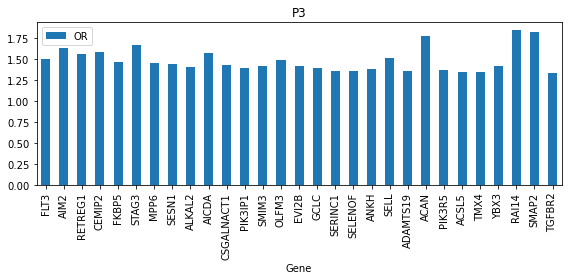

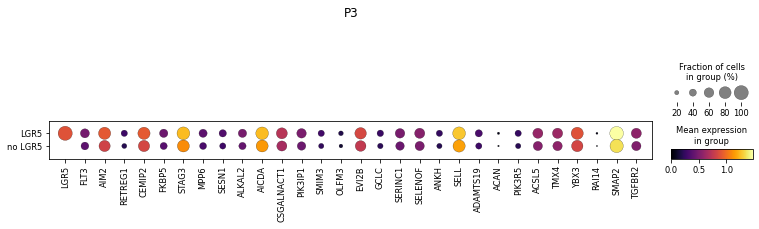

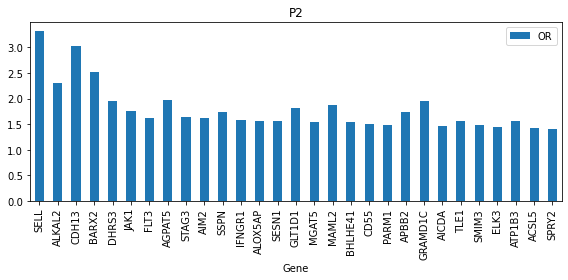

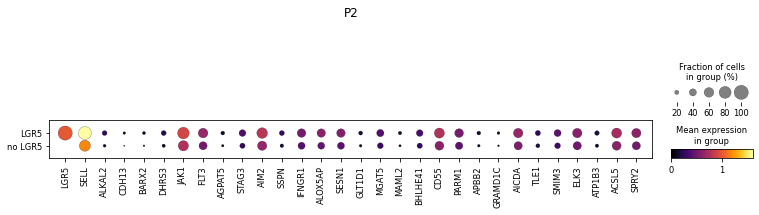

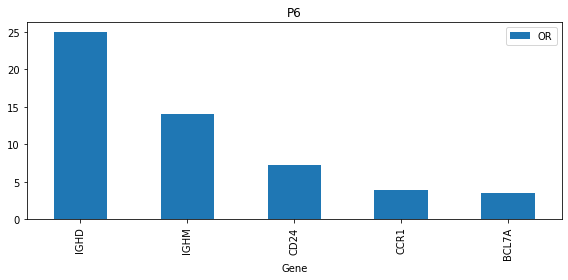

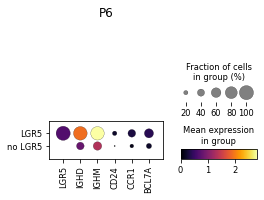

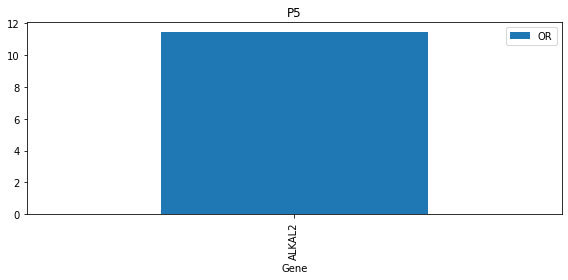

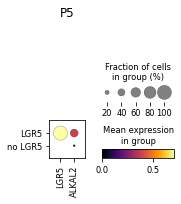

In [9]:
for p, res in results.items():
    res.to_csv(f"{out_dir}/coexpression_lgr5_{p}.csv")
    adata = adatas[p]
    adata.obs["expresses_LGR5"] = ["LGR5" if x else "no LGR5" for x in adata[:, "LGR5"].X]
    tmp_res = res.query("(FDR < 0.01) & (OR > 1)").sort_values(["p_value", "OR"], ascending=[True, False])
    if tmp_res.shape[0] <= 1:
        print(f"{p} has no genes co-expressed with LGR5")
        continue

    fig, ax = plt.subplots(figsize=(8, 4))
    tmp_res.loc[:, ["OR"]].iloc[1:30, :].plot.bar(title=p, ax=ax)
    fig.tight_layout()
    fig.savefig(f"{out_dir}/coexpression_lgr5_{p}_odds_ratio.pdf")
    ax = sc.pl.dotplot(
        adata,
        var_names=tmp_res.index[:30],
        groupby=["expresses_LGR5"],
        swap_axes=False,
        title=p,
        cmap="inferno",
        show=False,
    )
    ax["mainplot_ax"].get_figure().savefig(f"{out_dir}/coexpression_lgr5_{p}_dotplot.pdf", bbox_inches = 'tight')